In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
data_path='./Dataset'

In [3]:
os.listdir(data_path)

['class_identity.txt',
 'gender.csv',
 'gender_classification.csv',
 'gender_classification.xlsx',
 'Images',
 'list_attribute.txt']

In [4]:
data = pd.read_csv(data_path+'/gender.csv')
data

,image,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print("train: {}, test: {}, valid: {}".format(len(train_data), len(test_data), len(val_data)))

train: 4000, test: 500, valid: 500


In [6]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path)
        image = image.convert('RGB')

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [7]:
from keras.preprocessing.image import ImageDataGenerator

transform = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

transform = transforms.ToTensor()

In [8]:
batch_size = 32

train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

val_set = GenderDataset(val_data, os.path.join(data_path, "Images"), transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None):
    model = model.to(device)
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(num_epochs):
        start_training = time.perf_counter()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                model.eval()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            model.train()

        end_training = time.perf_counter()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100.0 * correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]\tTraining Loss: {epoch_loss:.4f}\tTraining Accuracy: {epoch_accuracy:.2f}%\t Time: {end_training-start_training:.2f}s')

        start_valid = time.perf_counter()
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_Loss = criterion(val_outputs, val_labels)

                val_running_loss += val_Loss.item()
                _, val_predicted = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += val_predicted.eq(val_labels).sum().item()

        end_valid = time.perf_counter()
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = 100.0 * val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}]\tValidation Loss: {val_epoch_loss:.4f}\tValidation Accuracy: {val_epoch_accuracy:.2f}%\t Time: {end_valid-start_valid:.2f}s')

        if scheduler != None:
            scheduler.step()
            print("Scheduler active")

    return train_loss, train_accuracy, val_loss, val_accuracy

In [11]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100.0 * correct / total

    precision = precision_score(true_labels, predicted_labels) * 100
    recall = recall_score(true_labels, predicted_labels) * 100
    f1 = f1_score(true_labels, predicted_labels) * 100

    print(f'Accuracy:\t{test_accuracy:.2f}%')
    print(f'Precision:\t{precision:.2f}%')
    print(f'Recall:\t\t{recall:.2f}%')
    print(f'F1-Score:\t{f1:.2f}%')
    print(f'Loss:\t\t{test_loss:.4f}')

In [12]:
def plotting(train_loss, val_loss, train_accuracy, val_accuracy):
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [13]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay = 0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [14]:
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/20]	Training Loss: 0.6764	Training Accuracy: 58.48%	 Time: 44.01s
Epoch [1/20]	Validation Loss: 0.6715	Validation Accuracy: 59.00%	 Time: 2.56s
Epoch [2/20]	Training Loss: 0.6574	Training Accuracy: 60.12%	 Time: 49.35s
Epoch [2/20]	Validation Loss: 0.5884	Validation Accuracy: 68.40%	 Time: 2.57s
Epoch [3/20]	Training Loss: 0.6140	Training Accuracy: 66.50%	 Time: 49.31s
Epoch [3/20]	Validation Loss: 0.5464	Validation Accuracy: 72.40%	 Time: 2.57s
Epoch [4/20]	Training Loss: 0.5612	Training Accuracy: 72.60%	 Time: 49.48s
Epoch [4/20]	Validation Loss: 0.5372	Validation Accuracy: 72.20%	 Time: 2.57s
Epoch [5/20]	Training Loss: 0.5272	Training Accuracy: 74.25%	 Time: 49.47s
Epoch [5/20]	Validation Loss: 0.5567	Validation Accuracy: 74.80%	 Time: 2.52s
Epoch [6/20]	Training Loss: 0.5271	Training Accuracy: 74.12%	 Time: 49.40s
Epoch [6/20]	Validation Loss: 0.4911	Validation Accuracy: 76.60%	 Time: 2.57s
Epoch [7/20]	Training Loss: 0.4828	Training Accuracy: 76.95%	 Time: 49.20s
Epoch [

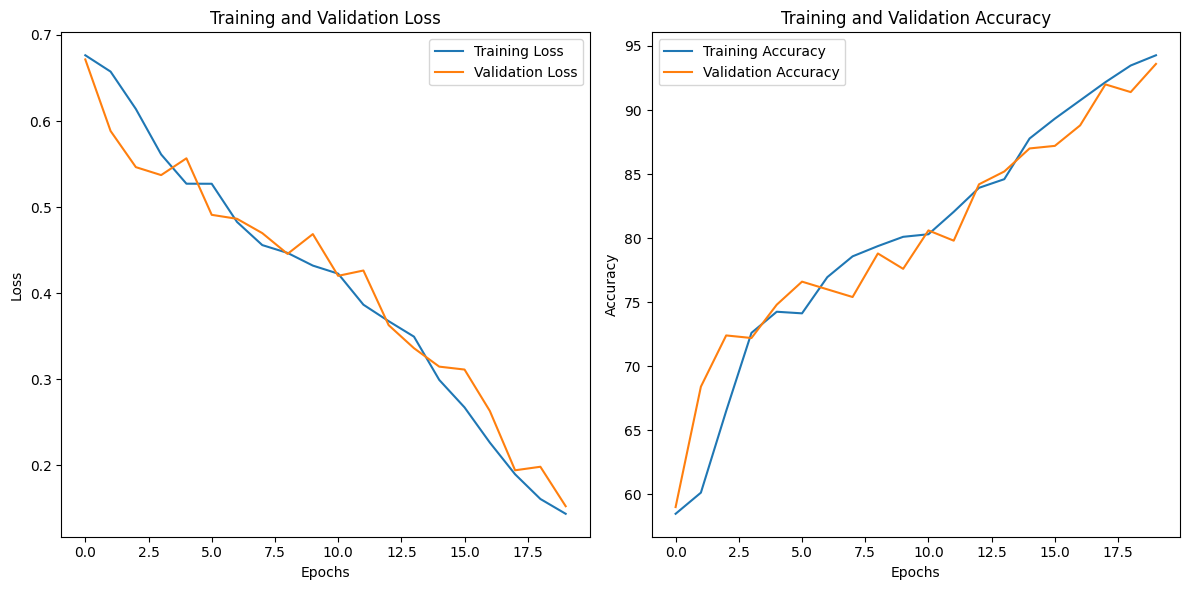

In [15]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [16]:
evaluate(model, test_loader, criterion)

Accuracy:	93.00%
Precision:	89.05%
Recall:		93.97%
F1-Score:	91.44%
Loss:		0.1954


In [17]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.002, weight_decay = 0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [18]:
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/20]	Training Loss: 0.6779	Training Accuracy: 58.85%	 Time: 49.41s
Epoch [1/20]	Validation Loss: 0.6668	Validation Accuracy: 59.00%	 Time: 2.47s
Epoch [2/20]	Training Loss: 0.6566	Training Accuracy: 60.45%	 Time: 49.08s
Epoch [2/20]	Validation Loss: 0.6528	Validation Accuracy: 59.20%	 Time: 2.48s
Epoch [3/20]	Training Loss: 0.6148	Training Accuracy: 65.47%	 Time: 49.03s
Epoch [3/20]	Validation Loss: 0.5562	Validation Accuracy: 71.20%	 Time: 2.49s
Epoch [4/20]	Training Loss: 0.5859	Training Accuracy: 69.03%	 Time: 49.16s
Epoch [4/20]	Validation Loss: 0.5376	Validation Accuracy: 73.80%	 Time: 2.49s
Epoch [5/20]	Training Loss: 0.5417	Training Accuracy: 72.78%	 Time: 252.10s
Epoch [5/20]	Validation Loss: 0.5056	Validation Accuracy: 75.60%	 Time: 2.62s
Epoch [6/20]	Training Loss: 0.5178	Training Accuracy: 75.38%	 Time: 50.39s
Epoch [6/20]	Validation Loss: 0.5142	Validation Accuracy: 73.40%	 Time: 2.61s
Epoch [7/20]	Training Loss: 0.4916	Training Accuracy: 76.88%	 Time: 49.65s
Epoch 

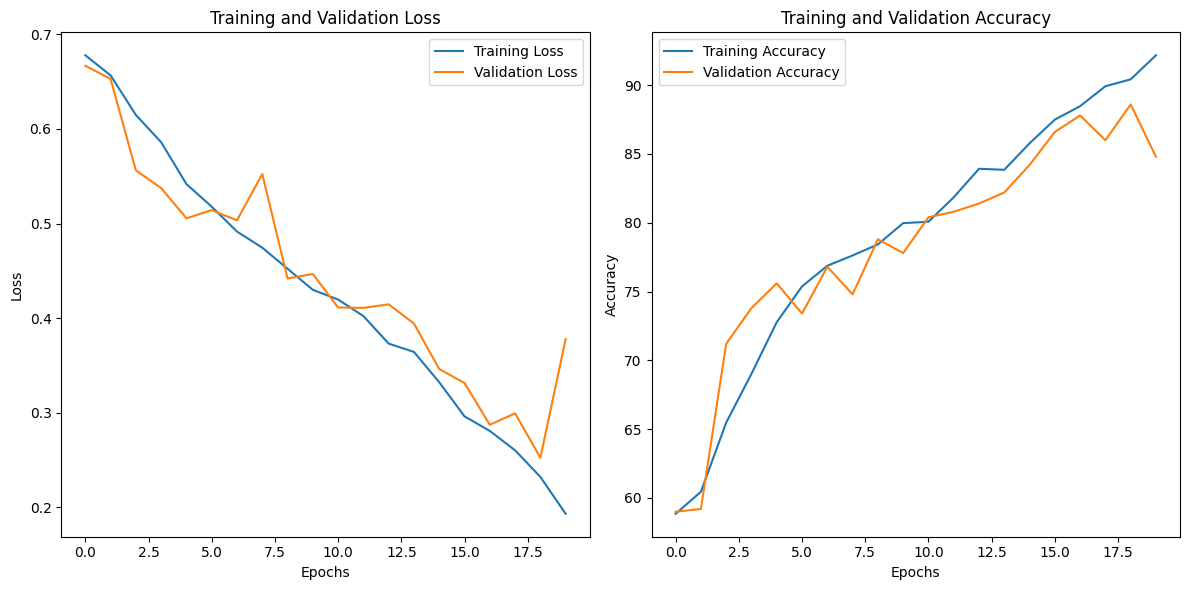

In [19]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [20]:
evaluate(model, test_loader, criterion)

Accuracy:	85.80%
Precision:	92.11%
Recall:		70.35%
F1-Score:	79.77%
Loss:		0.3509


In [21]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [22]:
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/20]	Training Loss: 0.6765	Training Accuracy: 58.23%	 Time: 51.91s
Epoch [1/20]	Validation Loss: 0.6757	Validation Accuracy: 59.00%	 Time: 2.63s
Epoch [2/20]	Training Loss: 0.6713	Training Accuracy: 58.92%	 Time: 59.30s
Epoch [2/20]	Validation Loss: 0.6660	Validation Accuracy: 59.00%	 Time: 2.80s
Epoch [3/20]	Training Loss: 0.6597	Training Accuracy: 59.73%	 Time: 62.05s
Epoch [3/20]	Validation Loss: 0.6325	Validation Accuracy: 59.80%	 Time: 2.79s
Epoch [4/20]	Training Loss: 0.6202	Training Accuracy: 64.17%	 Time: 53.83s
Epoch [4/20]	Validation Loss: 0.5771	Validation Accuracy: 68.00%	 Time: 2.55s
Epoch [5/20]	Training Loss: 0.5722	Training Accuracy: 70.42%	 Time: 49.85s
Epoch [5/20]	Validation Loss: 0.5561	Validation Accuracy: 70.00%	 Time: 2.59s
Epoch [6/20]	Training Loss: 0.5416	Training Accuracy: 72.67%	 Time: 49.73s
Epoch [6/20]	Validation Loss: 0.4977	Validation Accuracy: 76.20%	 Time: 2.56s
Epoch [7/20]	Training Loss: 0.5005	Training Accuracy: 75.62%	 Time: 49.86s
Epoch [

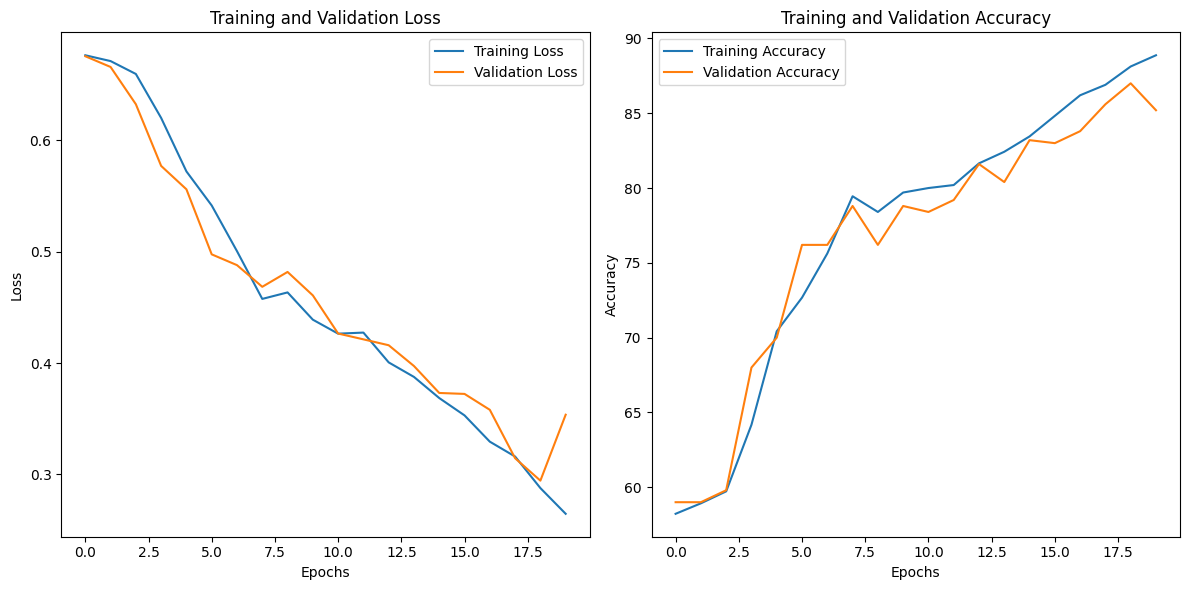

In [23]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [24]:
evaluate(model, test_loader, criterion)

Accuracy:	85.00%
Precision:	73.66%
Recall:		96.98%
F1-Score:	83.73%
Loss:		0.4028


In [27]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [28]:
num_epochs = 20
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler)

Epoch [1/20]	Training Loss: 0.6750	Training Accuracy: 58.95%	 Time: 51.12s
Epoch [1/20]	Validation Loss: 0.6645	Validation Accuracy: 59.00%	 Time: 2.73s
Scheduler active
Epoch [2/20]	Training Loss: 0.6522	Training Accuracy: 60.88%	 Time: 49.66s
Epoch [2/20]	Validation Loss: 0.5844	Validation Accuracy: 69.20%	 Time: 2.59s
Scheduler active
Epoch [3/20]	Training Loss: 0.6156	Training Accuracy: 67.15%	 Time: 50.06s
Epoch [3/20]	Validation Loss: 0.5643	Validation Accuracy: 71.60%	 Time: 2.69s
Scheduler active
Epoch [4/20]	Training Loss: 0.5432	Training Accuracy: 73.15%	 Time: 53.15s
Epoch [4/20]	Validation Loss: 0.5581	Validation Accuracy: 71.00%	 Time: 2.96s
Scheduler active
Epoch [5/20]	Training Loss: 0.5081	Training Accuracy: 75.95%	 Time: 52.71s
Epoch [5/20]	Validation Loss: 0.5066	Validation Accuracy: 75.60%	 Time: 2.58s
Scheduler active
Epoch [6/20]	Training Loss: 0.4466	Training Accuracy: 79.30%	 Time: 49.92s
Epoch [6/20]	Validation Loss: 0.4556	Validation Accuracy: 77.80%	 Time: 2.5

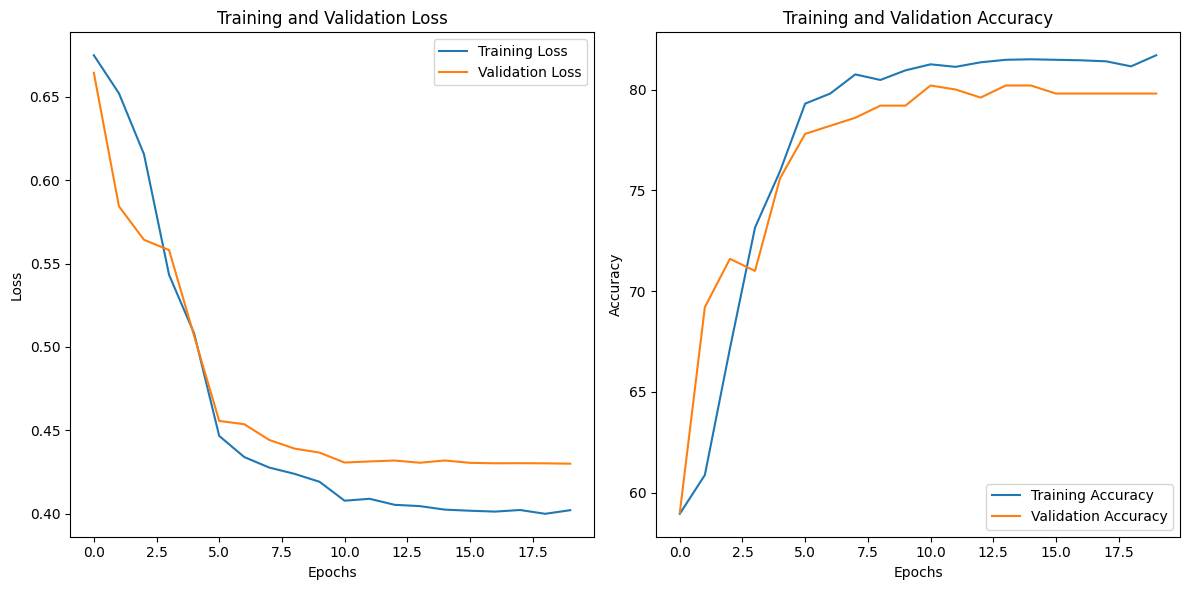

In [29]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [30]:
evaluate(model, test_loader, criterion)

Accuracy:	83.20%
Precision:	79.19%
Recall:		78.39%
F1-Score:	78.79%
Loss:		0.4026


In [35]:
model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.004, weight_decay = 0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [39]:
num_epochs = 10
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]	Training Loss: 0.3977	Training Accuracy: 82.72%	 Time: 50.77s
Epoch [1/10]	Validation Loss: 0.4030	Validation Accuracy: 81.00%	 Time: 3.09s
Epoch [2/10]	Training Loss: 0.3814	Training Accuracy: 83.10%	 Time: 54.85s
Epoch [2/10]	Validation Loss: 0.4132	Validation Accuracy: 80.60%	 Time: 2.96s
Epoch [3/10]	Training Loss: 0.3548	Training Accuracy: 84.20%	 Time: 64.46s
Epoch [3/10]	Validation Loss: 0.3925	Validation Accuracy: 81.60%	 Time: 2.69s
Epoch [4/10]	Training Loss: 0.3191	Training Accuracy: 86.60%	 Time: 50.68s
Epoch [4/10]	Validation Loss: 0.3394	Validation Accuracy: 84.00%	 Time: 2.62s
Epoch [5/10]	Training Loss: 0.2984	Training Accuracy: 87.70%	 Time: 50.86s
Epoch [5/10]	Validation Loss: 0.3186	Validation Accuracy: 86.40%	 Time: 2.60s
Epoch [6/10]	Training Loss: 0.2702	Training Accuracy: 88.92%	 Time: 50.41s
Epoch [6/10]	Validation Loss: 0.2725	Validation Accuracy: 87.20%	 Time: 2.64s
Epoch [7/10]	Training Loss: 0.2267	Training Accuracy: 90.72%	 Time: 58.11s
Epoch [

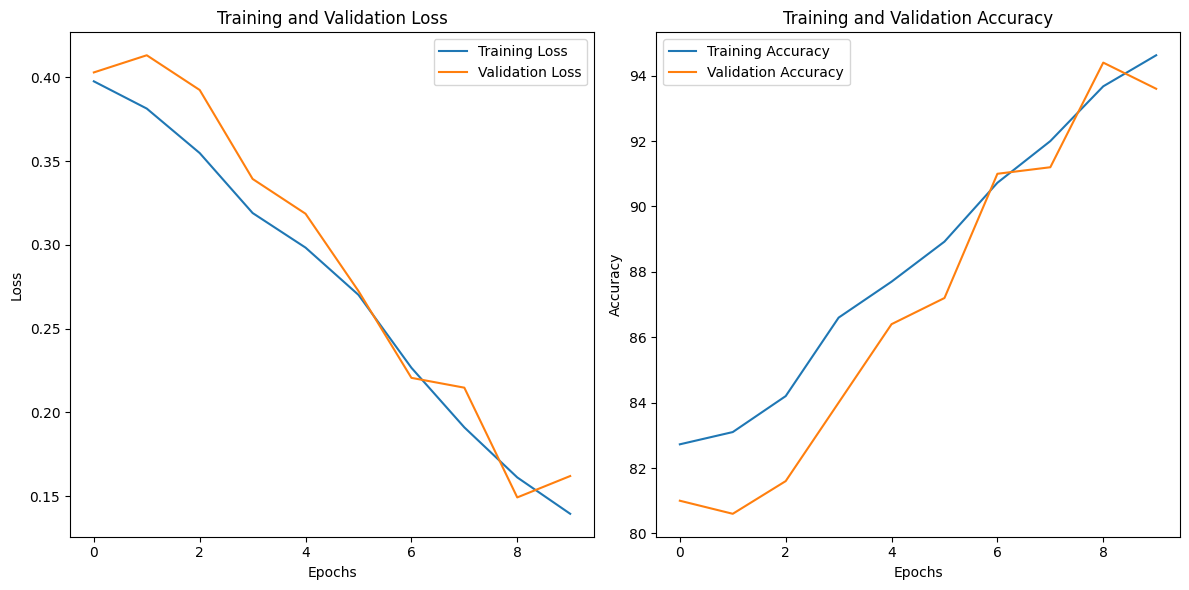

In [40]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [42]:
evaluate(model, test_loader, criterion)

Accuracy:	91.60%
Precision:	86.18%
Recall:		93.97%
F1-Score:	89.90%
Loss:		0.2411


In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.003, weight_decay = 0.005, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [22]:
num_epochs = 10
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]	Training Loss: 0.2250	Training Accuracy: 90.60%	 Time: 55.46s
Epoch [1/10]	Validation Loss: 0.1166	Validation Accuracy: 96.00%	 Time: 3.07s
Epoch [2/10]	Training Loss: 0.1015	Training Accuracy: 95.97%	 Time: 61.30s
Epoch [2/10]	Validation Loss: 0.1703	Validation Accuracy: 93.40%	 Time: 3.05s
Epoch [3/10]	Training Loss: 0.0428	Training Accuracy: 98.67%	 Time: 50.43s
Epoch [3/10]	Validation Loss: 0.1345	Validation Accuracy: 95.00%	 Time: 2.63s
Epoch [4/10]	Training Loss: 0.0400	Training Accuracy: 98.42%	 Time: 50.72s
Epoch [4/10]	Validation Loss: 0.0729	Validation Accuracy: 98.00%	 Time: 2.62s
Epoch [5/10]	Training Loss: 0.0267	Training Accuracy: 99.00%	 Time: 50.35s
Epoch [5/10]	Validation Loss: 0.0772	Validation Accuracy: 98.00%	 Time: 2.61s
Epoch [6/10]	Training Loss: 0.0049	Training Accuracy: 99.85%	 Time: 50.68s
Epoch [6/10]	Validation Loss: 0.0999	Validation Accuracy: 97.80%	 Time: 2.59s
Epoch [7/10]	Training Loss: 0.0062	Training Accuracy: 99.78%	 Time: 50.42s
Epoch [

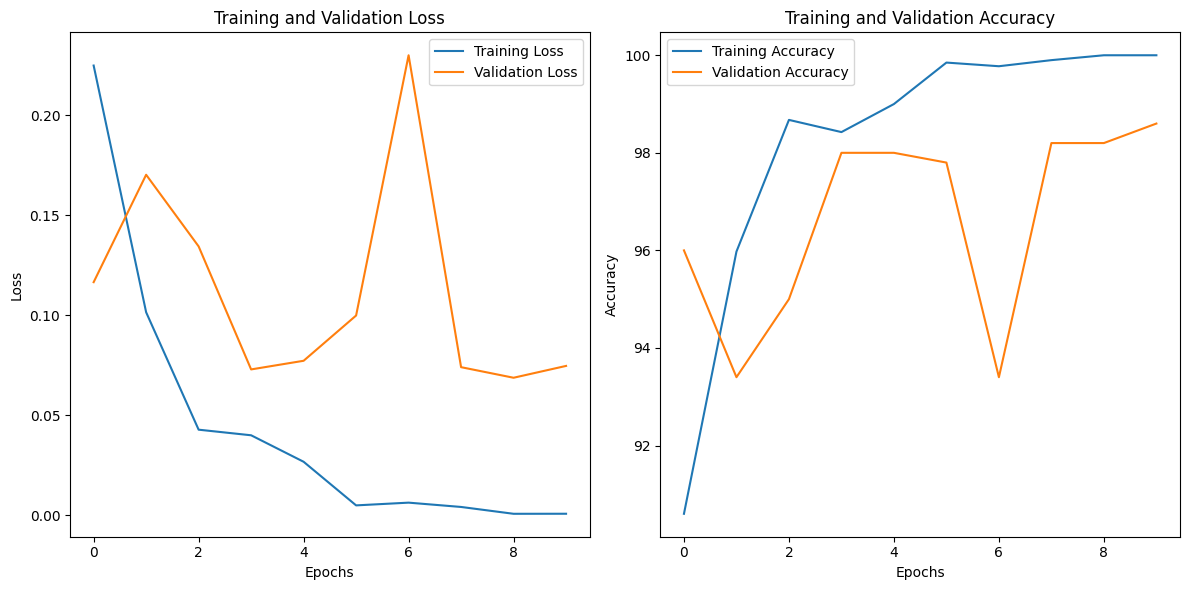

In [23]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [24]:
evaluate(model, test_loader, criterion)

Accuracy:	97.60%
Precision:	96.52%
Recall:		97.49%
F1-Score:	97.00%
Loss:		0.1071


In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [34]:
num_epochs = 10
train_loss, train_accuracy, val_loss, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]	Training Loss: 0.2641	Training Accuracy: 88.92%	 Time: 27.52s
Epoch [1/10]	Validation Loss: 0.1303	Validation Accuracy: 95.40%	 Time: 1.33s
Epoch [2/10]	Training Loss: 0.0964	Training Accuracy: 96.30%	 Time: 27.10s
Epoch [2/10]	Validation Loss: 0.1546	Validation Accuracy: 94.20%	 Time: 1.29s
Epoch [3/10]	Training Loss: 0.0517	Training Accuracy: 98.22%	 Time: 26.88s
Epoch [3/10]	Validation Loss: 0.0884	Validation Accuracy: 97.00%	 Time: 1.29s
Epoch [4/10]	Training Loss: 0.0177	Training Accuracy: 99.55%	 Time: 27.01s
Epoch [4/10]	Validation Loss: 0.1078	Validation Accuracy: 97.40%	 Time: 1.30s
Epoch [5/10]	Training Loss: 0.0317	Training Accuracy: 98.70%	 Time: 27.01s
Epoch [5/10]	Validation Loss: 0.1182	Validation Accuracy: 97.00%	 Time: 1.30s
Epoch [6/10]	Training Loss: 0.0105	Training Accuracy: 99.67%	 Time: 26.94s
Epoch [6/10]	Validation Loss: 0.0987	Validation Accuracy: 97.60%	 Time: 1.30s
Epoch [7/10]	Training Loss: 0.0033	Training Accuracy: 99.90%	 Time: 26.93s
Epoch [

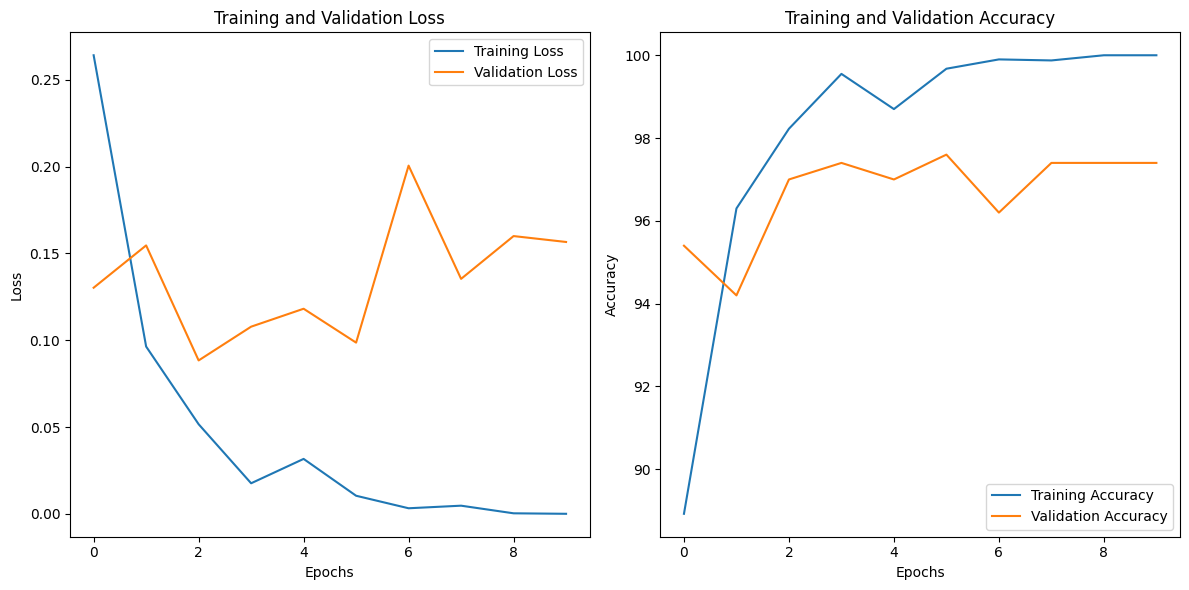

In [35]:
plotting(train_loss, val_loss, train_accuracy, val_accuracy)

In [36]:
evaluate(model, test_loader, criterion)

Accuracy:	97.80%
Precision:	97.47%
Recall:		96.98%
F1-Score:	97.23%
Loss:		0.2107
